In [1]:
import json
from Bio import SeqIO, Phylo, Seq
from string import digits
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [4]:
def CDS_finder(reference):
    """this function finds CDS location and not CDS location, and saves only those not located at the end of the function"""
    cds_ = dict()
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_[feature.qualifiers['gene'][0]] = (list(feature.location))
    return(cds_)

ref_file = SeqIO.read("data/areference.gbk", "genbank")

def Synonymous_Mutations(node, dictionary_=None, new_=None):
    """ Finds Synonymous mutations in CDS regions. Input:nested json"""
    gene_cds = CDS_finder(ref_file)
    if new_ is None: new_ = []
    if dictionary_ is None: dictionary_ = dict()
    if 'mutations' in node['branch_attrs']:
        aa_mutations, new_, in_it = ([] for i in range(3))
        if 'nuc' in node['branch_attrs']['mutations']:
            for gene, loc in gene_cds.items():
                if gene in node['branch_attrs']['mutations']:
                    for mut in node['branch_attrs']['mutations'][gene]:
                        aa_mutations.append(int(mut[1:-1])*3+loc[0]) # converting the amino acid location to nucleotide
            for mut in node['branch_attrs']['mutations']['nuc']:
                if '-' not in mut and '*' not in mut and 'N' not in mut and "R" not in mut and "Y" not in mut and "M" not in mut and "D" not in mut:
                    if int(mut[1:-1]) not in aa_mutations and int(mut[1:-1])+2 not in aa_mutations and int(mut[1:-1])+1 not in aa_mutations:  #if the mutation is not in the same codon as a aa mutation
                        new_.append(mut)
                    else: in_it.append(mut[1:-1])
    if 'name' in node:
            dictionary_[node['name']] = new_
    if 'children' in node:
        for child in node['children']:
           Synonymous_Mutations(child, dictionary_, new_=None)
    return(dictionary_)


ref_file = SeqIO.read("data/areference.gbk", "genbank")
with open ("data/rsv_a_genome.json") as file_: f = json.load(file_)  
synonymous = Synonymous_Mutations(f['tree'])

#Extracting all synonymous mutations from json as a list
all_muts = []
for branch, muts in synonymous.items():
    if branch != []:
        for mut in muts:
            if mut[0] and mut[-1] in ["A", "T", "C", "G"]:
                all_muts.append(f'{mut[0]}{mut[-1]}')
all_muts_counter = Counter(all_muts)

#making matrix with mutation rates
df = pd.DataFrame(index=['A', 'C', 'G', 'T'], columns=['A', 'C', 'G', 'T'])      

for mutation, nr in all_muts_counter.items():
    df.at[mutation[0], mutation[-1]] = int(nr)
print("matrix unscaled synonymous")
print(df)


#now have to divide by the nr of locations where the mutation can occur
ref_file = SeqIO.read("data/areference.gbk", "genbank")
gene_cds = CDS_finder(ref_file)

sequence_ref_cds = dict()
whole_seq_CDS = ""
for gene, cds in gene_cds.items(): 
    sequence_ref_cds[gene] = ref_file.seq[cds[0]:cds[-1]]
    whole_seq_CDS = whole_seq_CDS+ref_file.seq[cds[0]:cds[-1]]

#translation matrix
translations = {'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'], 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'], 'C': ['TGT', 'TGC'], 'W': ['TGG'], 'E': ['GAA', 'GAG'], 'D': ['GAT', 'GAC'], 'P': ['CCT', 'CCC', 'CCA', 'CCG'], 'V': ['GTT', 'GTC', 'GTA', 'GTG'], 'N': ['AAT', 'AAC'], 'M': ['ATG'], 'K': ['AAA', 'AAG'], 'Y': ['TAT', 'TAC'], 'I': ['ATT', 'ATC', 'ATA'], 'Q': ['CAA', 'CAG'], 'F': ['TTT', 'TTC'], 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'], 'T': ['ACT', 'ACC', 'ACA', 'ACG'], '*': ['TAA', 'TAG', 'TGA'], 'A': ['GCT', 'GCC', 'GCA', 'GCG'], 'G': ['GGT', 'GGC', 'GGA', 'GGG'], 'H': ['CAT', 'CAC']}


synonymous_possibilities, nonsynonymous_possibilities = (0 for i in range(2))
for gene, sequence in sequence_ref_cds.items():
    for i, letter in enumerate(sequence):
        if i%3 == 0:
            codon = sequence[i: i+3]
            for key, entry in translations.items():
                if codon in entry:
                    synonymous = len(entry)
                    synonymous_possibilities += synonymous-1 
                    nonsynonymous = 9 - len(entry)-1
                    nonsynonymous_possibilities += nonsynonymous

nonsyn_ratio = nonsynonymous_possibilities/(nonsynonymous_possibilities+synonymous_possibilities)
syn_ratio = synonymous_possibilities/(nonsynonymous_possibilities+synonymous_possibilities)

print("\n","syn  fractions")
print(syn_ratio)

print("\n","scaled by syn ratio")
scaled = df.divide(syn_ratio)
scaled = scaled.fillna(0)
print(scaled)

print("\n", "ratio of nt", "\n")
counter = Counter(whole_seq_CDS)
total = 0
for i in counter.values(): total += i

df_ratios = pd.DataFrame.from_dict(counter, orient='index').astype(int).T
df_ratios = df_ratios.divide(total)
print(df_ratios)

nuc = ["A", "C", "G", "T"]
for n in nuc:
    scaled.loc[[n]] = scaled.loc[[n]].div(float(df_ratios[n]))

print(scaled)

print("\n", "normalized and scaled matrix")

sum_ = scaled.to_numpy().sum()
print("sum of all:",  sum_, "\n")

scaled_and_normalized = scaled.divide(sum_)
print(scaled_and_normalized)


matrix unscaled synonymous
      A     C     G     T
A   NaN   249  2342   662
C   589   NaN    28  4079
G  2301    10   NaN   168
T   541  4138   116   NaN

 syn  fractions
0.34887810367869454

 scaled by syn ratio
             A             C            G             T
A     0.000000    713.716331  6712.946371   1897.510887
C  1688.268750      0.000000    80.257258  11691.762702
G  6595.426815     28.663306     0.000000    481.543548
T  1550.684879  11860.876210   332.494355      0.000000

 ratio of nt 

          A         T         G         C         N         M
0  0.358882  0.259638  0.150699  0.164822  0.065883  0.000076
              A             C             G             T
A      0.000000   1988.719467  18705.144547   5287.278262
C  10242.997849      0.000000    486.933684  70935.803441
G  43765.702048    190.202964      0.000000   3195.409798
T   5972.484925  45682.333864   1280.606749      0.000000

 normalized and scaled matrix
sum of all: 207733.6175974809 

          A

A    0.125070
C    0.393127
G    0.226980
T    0.254824
dtype: float64
{2: 0.22697970292575742, 4: 0.3520492153921362, 6: 0.47711872785851495, 8: 0.8702459256521333, 10: 1.1250695124663785, 12: 1.518196710259997, 14: 1.9113239080536153, 16: 2.304451105847234, 18: 2.429520618313613, 20: 2.8226478161072315, 22: 3.21577501390085, 24: 3.4705986007150953, 26: 3.863725798508714, 28: 3.9887953109750924, 30: 4.21577501390085, 32: 4.608902211694469, 34: 4.733971724160847, 36: 5.127098921954466, 38: 5.252168434420844, 40: 5.479148137346602, 42: 5.872275335140221, 44: 5.997344847606599, 46: 6.390472045400218, 48: 6.783599243193836, 50: 6.908668755660215, 52: 7.16349234247446, 54: 7.418315929288705, 56: 7.6731395161029505, 58: 8.06626671389657, 60: 8.191336226362948, 62: 8.316405738829326, 64: 8.709532936622944, 66: 8.9365126395487, 68: 9.191336226362946}
{2: 0.22697970292575742, 4: 0.3520492153921362, 6: 0.47711872785851495, 8: 0.8702459256521333, 10: 1.1250695124663785, 12: 1.518196710259997, 14

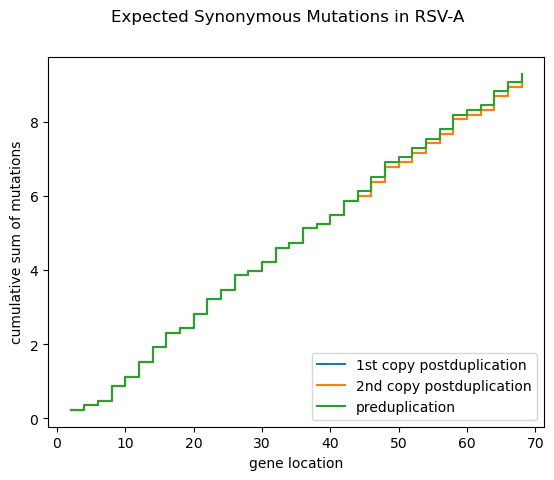

In [104]:
sum_of_rows = scaled_and_normalized.sum(axis = 1)
print(sum_of_rows)
tree_file  = Phylo.read("data/a_tree.nwk", "newick")
tree_file.root_at_midpoint()
tree_file.find_clades()
total_len = tree_file.total_branch_length()
duplication_file = SeqIO.parse("data/last_reconstruction.fasta", "fasta")
seq_dict = dict()
for record in duplication_file:
    seq_dict[record.id] = record.seq
for branch in tree_file.get_nonterminals(order='preorder'):
    if pd.isna(branch.name) == False:
        if '-'*int(72) not in seq_dict[branch.name]:
            first_dupl_sequence = seq_dict[branch.name]
            with_dupl = branch.total_branch_length()
            break  
for branch in tree_file.get_nonterminals(order='preorder'):
    if pd.isna(branch.name) == False:
            first_predupl_sequence = seq_dict[branch.name][72:][1:-2]
            break  
without_dupl = total_len-with_dupl


post_dupl_1 = first_dupl_sequence[:72][1:-2]
post_dupl_2 = first_dupl_sequence[72:][1:-2]
#print(post_dupl_1)
#print(post_dupl_2)
#print(first_predupl_sequence)

#print(post_dupl_1)
##muts_at_position = dict()
#for i, letter in enumerate(post_dupl_1):
#        if i%3 == 0:
#            sum_at_pos_0 = 0
#            sum_at_pos_3 = 0
#            codon = post_dupl_1[i: i+3]
#            for key, entry in translations.items():
#                if codon in entry:
#                    for c in entry:
#                        if c != codon:
#                            if c[0] == codon[0]: sum_at_pos_3= float(sum_at_pos_3) + float(scaled_and_normalized.at[codon[-1], c[-1]])
#                            if c[0] != codon[0]: sum_at_pos_0 = float(sum_at_pos_3) + float(scaled_and_normalized.at[codon[0], c[0]])
#            muts_at_position[i] = float(sum_at_pos_0)
#            muts_at_position[i+3] = float(sum_at_pos_3)
#print(muts_at_position)


cumulative_1, cumulative_2, cumulative_pre = (dict() for i in range(3))
cumulative = 0
for i, character in enumerate(post_dupl_1):
    if i%2 != 0:
        cumulative+= sum_of_rows[character]
        cumulative_1[i+1] =cumulative

cumulative = 0
for i, character in enumerate(post_dupl_2):
    if i%2 != 0:
        cumulative+= sum_of_rows[character]
        cumulative_2[i+1] =cumulative

cumulative = 0
for i, character in enumerate(first_predupl_sequence):
    if i%2 !=0:
        cumulative+= sum_of_rows[character]
        cumulative_pre[i+1] =cumulative
    

print(cumulative_1)
print(cumulative_2)
print(cumulative_pre)
#axs = plt.plot()
plt.step(cumulative_1.keys(), cumulative_1.values(), label= f'1st copy postduplication', where='post')
plt.step(cumulative_2.keys(), cumulative_2.values(), label=f'2nd copy postduplication', where='post' )
plt.step(cumulative_pre.keys(), cumulative_pre.values(), label= f'preduplication', where='post' )
plt.legend(loc='lower right')
plt.suptitle('Expected Synonymous Mutations in RSV-A')
plt.xlabel("gene location")
plt.ylabel("cumulative sum of mutations")
plt.savefig("expected_synonymous.png")

In [107]:
# For mutation rates including context


ref_file = SeqIO.read("data/areference.gbk", "genbank")

def Synonymous_Mutations(node, dictionary_=None, new_=None):
    """ Finds Synonymous mutations in CDS regions. Input:nested json"""
    gene_cds = CDS_finder(ref_file)
    if new_ is None: new_ = []
    if dictionary_ is None: dictionary_ = dict()
    if 'mutations' in node['branch_attrs']:
        aa_mutations, new_, in_it = ([] for i in range(3))
        if 'nuc' in node['branch_attrs']['mutations']:
            for gene, loc in gene_cds.items():
                if gene in node['branch_attrs']['mutations']:
                    for mut in node['branch_attrs']['mutations'][gene]:
                        aa_mutations.append(int(mut[1:-1])*3+loc[0]) # converting the amino acid location to nucleotide
            for mut in node['branch_attrs']['mutations']['nuc']:
                if '-' not in mut and '*' not in mut and 'N' not in mut and "R" not in mut and "Y" not in mut and "M" not in mut and "D" not in mut:
                    if int(mut[1:-1]) not in aa_mutations and int(mut[1:-1])+2 not in aa_mutations and int(mut[1:-1])+1 not in aa_mutations:  #if the mutation is not in the same codon as a aa mutation
                        new_.append(mut)
                    else: in_it.append(mut[1:-1])
    if 'name' in node:
            dictionary_[node['name']] = new_
    if 'children' in node:
        for child in node['children']:
           Synonymous_Mutations(child, dictionary_, new_=None)
    return(dictionary_)


ref_file = SeqIO.read("data/areference.gbk", "genbank")
with open("data/rsv_a_genome.json") as file_: f = json.load(file_)  
synonymous = Synonymous_Mutations(f['tree'])

#Extracting all synonymous mutations from json as a list

all_muts = []
mut_by_branch_CDS, all_dinucleotides = (defaultdict(list) for i in range(2))
for branch, muts in synonymous.items():
    if branch != []:
        for mut in muts:
            if mut[0] and mut[-1] in ["A", "T", "C", "G"]:
                mut_by_branch_CDS[branch].append(mut)
                all_muts.append(f'{mut[0]}{mut[-1]}')
all_muts_counter = Counter(all_muts)

aligned_for_tree = SeqIO.parse("data/reconstructed_sequences.fasta", "fasta")
for entry in aligned_for_tree:
    for i in mut_by_branch_CDS[entry.id]:
        location_of_interest = int(i[1:-1])
        #dinucleotide_and_mut = entry.seq[location_of_interest-2] + f'{i[0]}{i[-1]}'
        if entry.seq[location_of_interest-2] != '-':
            all_dinucleotides[f'{entry.seq[location_of_interest-2]}{i[0]}'].append(i[-1])

with_counters = dict()
for type, mut in all_dinucleotides.items():
    with_counters[type] = Counter(mut)

#making matrix with mutation rates
df_dinucl = pd.DataFrame(index=['AA', 'CA', 'GA', 'TA', 'AC', 'CC', 'GC', 'TC', 'AG', 'CG', 'GG', 'TG' ,'AT', 'CT', 'GT', 'TT'], columns=['A', 'C', 'G', 'T'])      

for mutation, count in with_counters.items():
    if 'N' not in mutation:
        for type, c in count.items():
            df_dinucl.at[mutation, type] = c
    #print("matrix unscaled synonymous")
print(df_dinucl)

print("\n","scaled by syn ratio")
scaled_dinucl = df_dinucl.divide(syn_ratio)
scaled_dinucl = scaled_dinucl.fillna(0)
print(scaled_dinucl)



print("\n", "ratio of nt", "\n")
whole_seq_CDS = ""
for gene, cds in gene_cds.items(): 
    whole_seq_CDS = whole_seq_CDS+ref_file.seq[cds[0]:cds[-1]]
all_CDS_char = []
for i, char in enumerate(whole_seq_CDS):
    if i !=0:
        all_CDS_char.append(str(whole_seq_CDS[i-1:i+1]))
counter = Counter(all_CDS_char)
total = 0
for i in counter.values(): total += i

df_ratios_dupl = pd.DataFrame.from_dict(counter, orient='index').astype(int).T
df_ratios_dupl = df_ratios_dupl.divide(total)
print(df_ratios_dupl)



nuc = ['AA', 'CA', 'GA', 'TA', 'AC', 'CC', 'GC', 'TC', 'AG', 'CG', 'GG', 'TG' ,'AT', 'CT', 'GT', 'TT']
for n in nuc: scaled_dinucl.loc[[n]] = scaled_dinucl.loc[[n]].div(float(df_ratios_dupl[n]))
print(scaled_dinucl)


print("normalized", "\n")

sum_ = scaled_dinucl.to_numpy().sum()
print("sum of all:",  sum_, "\n")

scaled_and_normalized_dinucl = scaled_dinucl.divide(sum_)
print(scaled_and_normalized_dinucl)



      A     C    G     T
AA  NaN    83  894    75
CA  NaN   108  467   378
GA  NaN     9  299    63
TA  NaN    49  677   141
AC  125   NaN    3  1355
CC  192   NaN    5  1224
GC   46   NaN    3   483
TC  221   NaN   14   995
AG  907     1  NaN    36
CG  416     1  NaN    22
GG  280     4  NaN    16
TG  687     4  NaN    94
AT   84  1463   21   NaN
CT  226  1252   37   NaN
GT   44   573   17   NaN
TT  187   840   40   NaN

 scaled by syn ratio
              A            C            G            T
AA     0.000000   237.905444  2562.499597   214.974798
CA     0.000000   309.563710  1338.576411  1083.472984
GA     0.000000    25.796976   857.032863   180.578831
TA     0.000000   140.450202  1940.505847   404.152621
AC   358.291331     0.000000     8.598992  3883.878024
CC   550.335484     0.000000    14.331653  3508.388710
GC   131.851210     0.000000     8.598992  1384.437702
TC   633.459073     0.000000    40.128629  2851.998992
AG  2599.761895     2.866331     0.000000   103.187903
CG 